# Cookie cutter

The aim of this notebook is to produce summary statistics for Hazards over NCRA regions, with the flexibility to apply the method to any shapefile region.

Typical statistics include median, mean, min, max, 10th, 90th percentiles

This method has used guidance from [https://github.com/aus-ref-clim-data-nci/shapefiles/blob/master/python_tutorial.ipynb]

<div>
<img src="cookie_cutter.jpg" width="500" title="Cookie cutter"/>
</div>

## Step 1 - access needed packages

In [1]:
# navigate to correct working directory

In [2]:
cd /g/data/mn51/users/gt3409/plotting_maps/

/g/data/mn51/users/gt3409/plotting_maps


In [3]:
# import needed packages
from acs_area_statistics import acs_regional_stats, regions

In [4]:
import xarray as xr
import geopandas as gpd
import regionmask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [5]:
# read in the shapefile with regions you will use
# from acs_plotting_maps import regions_dict
# ncra_gdf = gpd.read_file(f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/ncra_regions/ncra_regions.shp')
# ncra_gdf["abbrevs"]=['VIC', 'NT','TAS', 'SA', 'NSW', 'WAN', 'WAS', 'SQ', 'NQ']
# regions = regionmask.from_geopandas(ncra_gdf, names="NAME", abbrevs="abbrevs")
regions

<regionmask.Regions 'unnamed'>
overlap:  None

Regions:
0  WANorth                          Western Australia North
1  WASouth                          Western Australia South
2      NSW New South Wales and Australian Capital Territory
3      VIC                                         Victoria
4       SA                                  South Australia
5      TAS                                         Tasmania
6       NT                               Northern Territory
7 QLDNorth                                 Queensland North
8 QLDSouth                                 Queensland South
9      AUS                                        Australia

[10 regions]

## Step 2 - Load and prepare data

Open the data you need. 


In [6]:
%%time 
# open Hazard data
# this is a slowish part of the code. It is likely to be reused if you're interested in calculating multiple statistics
filename = "/g/data/ia39/ncra/extratropical_storms/5km/RX1D_AGCD-05i_ACCESS-CM2_historical_r4i1p1f1_BOM_BARPA-R_v1-r1_annual.nc"
ds = xr.open_dataset(filename, use_cftime = True,)

CPU times: user 3.75 s, sys: 1.74 s, total: 5.49 s
Wall time: 10.1 s


In [7]:
ds

<xarray.Dataset> Size: 269MB
Dimensions:    (time: 55, bnds: 2, lon: 886, lat: 691)
Coordinates:
  * time       (time) object 440B 1960-07-02 00:00:00 ... 2014-07-02 12:00:00
  * lon        (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
  * lat        (lat) float64 6kB -44.5 -44.45 -44.4 ... -10.1 -10.05 -10.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 880B ...
    lon_bnds   (lon, bnds) float64 14kB ...
    lat_bnds   (lat, bnds) float64 11kB ...
    pr         (time, lat, lon) float64 269MB ...
Attributes: (12/48)
    CDI:                       Climate Data Interface version 2.0.5 (https://...
    source:                    historical run using CSIRO-ARCCSS ACCESS-CM2 r...
    institution:               Bureau of Meteorology
    Conventions:               CF-1.10, ACDD-1.3
    activity_id:               RCM
    title:                     Pre-processed model output in preparation for ...
    ...                        ...
    driving_experiment:        CSIRO-ARCCSS ACCESS-CM2; historical; r4i1p1f1
    driving_source_id:         ACCESS-CM2
    input_tracking_id:         043b77c3-c8db-4394-9486-49d0ae0a3e9c
    history:                   Thu Jun 06 12:17:46 2024: cdo mergetime /scrat...
    NCO:                       netCDF Operators version 5.0.5 (Homepage = htt...
    CDO:                       Climate Data Operators version 2.0.5 (https://...

## Step 3 - Create your mask

There's a range of ways to calculate your mask:
- **regions.mask_3D(ds)** will create a "mask" array that is ```True``` for all grid cells whose centre point falls within a particular state/territory and ```False``` elsewhere
- **regions.mask_3D_frac_approx(ds)** will calculate the fraction of each grid cell that overlaps with each shape
- **mask_10pct** you may create a mask from the fraction values we need to decide on a minimum overlap threshold. eg ```mask_10pct = frac >= 0.1```

Fractional masking```regions.mask_3D_frac_approx(ds)``` which will weigh each lat lon grid by the approximate fraction of the area that lay within the shapefile geometery. It  is probably the most accurate, but more expensive than the simple mask_3D.

The masking methods return an xr.DataArray with three dimensions:  **region**, **lat**, and **lon**.

In [8]:
# create your mask
# you only need one mask. here are two examples. 
# you can also is a keyword fro the function to calculate the mask, but if you're performing multiple calculations, this can be slow.

In [9]:
%%time
# calculate weighted mask this is a very slow part of the code and
# can be reused for any datasets using the same regions and the same lat lon
mask_frac = regions.mask_3D_frac_approx(ds)

CPU times: user 20 s, sys: 1.9 s, total: 21.9 s
Wall time: 21.9 s


In [10]:
%%time
mask_centred = regions.mask_3D(ds)

CPU times: user 3.96 s, sys: 226 ms, total: 4.19 s
Wall time: 4.18 s


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/regionmask/core/mask.py:444: UserWarning: Detected overlapping regions. As of v0.11.0 these are correctly taken into account. Note, however, that a different mask is returned than with older versions of regionmask. To suppress this warning, set `overlap=True` (to restore the old, incorrect, behaviour, set `overlap=False`).
  warnings.warn(


## Step 4: Use function
To apply mask calculate a statistic to summarise each region 

In [11]:
# calculate the stats using the acs_region_fractional_stats function
# the function can infer/calculate many of the inputs, but it will be faster to explicitly specify them in the function, eg var, dims, mask  

start, end = ("1991", "2010") 
dims = ("time", "lat", "lon")
var = "pr"
how = ["mean", "min", "max"]
outfile="out.csv"
mask = mask_frac

In [12]:
%%time
da_summary = acs_regional_stats(ds=ds, infile=filename, var=var,  mask = mask, how = how, )
da_summary

Could not save to /g/data/ia39/ncra/extratropical_storms/5km/RX1D_AGCD-05i_ACCESS-CM2_historical_r4i1p1f1_BOM_BARPA-R_v1-r1_annual_summary-mean-min-max_ncra-regions.csv
CPU times: user 15.5 s, sys: 4.88 s, total: 20.4 s
Wall time: 20.4 s


,abbrevs,names,pr_mean,pr_min,pr_max
region,,,,,
0,WANorth,Western Australia North,85.588212,4.326878,1052.140973
1,WASouth,Western Australia South,53.033748,4.867188,570.546182
2,NSW,New South Wales and Australian Capital Territory,56.773368,6.031250,627.268719
3,VIC,Victoria,47.720637,9.718750,346.596529
4,SA,South Australia,40.667591,4.195312,488.796660
5,TAS,Tasmania,55.370626,9.359375,274.210938
6,NT,Northern Territory,82.478823,5.766116,1101.637623
7,QLDNorth,Queensland North,89.227606,6.205206,1392.264187
8,QLDSouth,Queensland South,62.936760,3.367188,772.510127


In [13]:
%%time
da_summary = acs_regional_stats(ds=ds, mask = "fractional", how = ["mean", "min", "max"], outfile="out.csv")
da_summary

!warning very slow! Calculating fractional mask every time is very slow.         
Please calculate ```mask = regions.mask_3D_frac_approx(ds)``` before this function.
CPU times: user 34.9 s, sys: 6.3 s, total: 41.2 s
Wall time: 41.2 s


,abbrevs,names,pr_mean,pr_min,pr_max
region,,,,,
0,WANorth,Western Australia North,85.588212,4.326878,1052.140973
1,WASouth,Western Australia South,53.033748,4.867188,570.546182
2,NSW,New South Wales and Australian Capital Territory,56.773368,6.031250,627.268719
3,VIC,Victoria,47.720637,9.718750,346.596529
4,SA,South Australia,40.667591,4.195312,488.796660
5,TAS,Tasmania,55.370626,9.359375,274.210938
6,NT,Northern Territory,82.478823,5.766116,1101.637623
7,QLDNorth,Queensland North,89.227606,6.205206,1392.264187
8,QLDSouth,Queensland South,62.936760,3.367188,772.510127


In [14]:
da_summary.index.names

FrozenList(['region'])

In [18]:
"-".join(how)

'mean-min-max'

In [21]:
filename.replace(".nc", f"_stats-{'-'.join(how)}_ncra-regions.csv")

'/g/data/ia39/ncra/extratropical_storms/5km/RX1D_AGCD-05i_ACCESS-CM2_historical_r4i1p1f1_BOM_BARPA-R_v1-r1_annual_stats-mean-min-max_ncra-regions.csv'

In [15]:
df = acs_regional_stats(ds=ds, var=var,  mask = mask, how = how, dims = ("lat", "lon"))
df

abbrevs  \
time                region             
1960-07-02 00:00:00 0        WANorth   
                    1        WASouth   
                    2            NSW   
                    3            VIC   
                    4             SA   
...                              ...   
2014-07-02 12:00:00 5            TAS   
                    6             NT   
                    7       QLDNorth   
                    8       QLDSouth   
                    9            AUS   

                                                                       names  \
time                region                                                     
1960-07-02 00:00:00 0                                Western Australia North   
                    1                                Western Australia South   
                    2       New South Wales and Australian Capital Territory   
                    3                                               Victoria   
                    4                                        South Australia   
...                                                                      ...   
2014-07-02 12:00:00 5                                               Tasmania   
                    6                                     Northern Territory   
                    7                                       Queensland North   
                    8                                       Queensland South   
                    9                                              Australia   

                               pr_mean     pr_min       pr_max  
time                region                                      
1960-07-02 00:00:00 0        89.618737   7.000022   823.889309  
                    1        53.041262   9.007812   509.304687  
                    2        53.252494   9.891297   183.312500  
                    3        33.621128  11.250592   105.794121  
                    4        38.557442  10.743817   200.025427  
...                                ...        ...          ...  
2014-07-02 12:00:00 5        52.784145  15.742188   107.289062  
                    6       149.917958  22.326325   794.164062  
                    7       136.018911  25.390625   908.953125  
                    8        77.845938  14.327220   495.303888  
                    9        90.470647   8.814893  1036.731651  

[550 rows x 5 columns]

In [ ]:
acs_regional_stats(ds=ds, var=var, mask =mask_frac, start=start, end=end, dims = dims, how = ["mean", "min", "max"], outfile = )

In [ ]:
## extra things

In [17]:
da_p90 = acs_regional_stats(ds=ds, var=var, mask =mask_frac, start=start, end=end, dims = ("time", "lat", "lon"), how = "quantile", quantile=0.9)

In [18]:
%%time
# regional mean
da_mean = acs_regional_stats(ds=ds, var=var, mask =mask_frac, start=start, end=end, dims = ("time", "lat", "lon"), how = "mean")
da_mean

CPU times: user 464 ms, sys: 184 ms, total: 648 ms
Wall time: 644 ms


<xarray.DataArray 'pr_mean' (region: 10)> Size: 80B
array([48.29607028, 85.38559917, 56.84069119, 41.98991372, 57.87682356,
       78.22834357, 48.4225218 , 64.71085976, 90.65452625, 65.56061029])
Coordinates:
  * region   (region) int64 80B 0 1 2 3 4 5 6 7 8 9
    abbrevs  (region) <U3 120B 'VIC' 'NT' 'TAS' 'SA' ... 'WAS' 'SQ' 'NQ' 'AUS'
    names    (region) <U23 920B 'Victoria' 'Northern Territory' ... 'Australia'

In [19]:
%%time
# regional mean
da_max = acs_regional_stats(ds=ds, var=var, mask =mask_frac, start=start, end=end, dims = ("time", "lat", "lon"), how = "max")
da_max

CPU times: user 1.82 s, sys: 802 ms, total: 2.63 s
Wall time: 2.62 s


<xarray.DataArray 'pr_max' (region: 10)> Size: 80B
array([ 275.75      , 1101.63898727,  254.23437444,  430.078125  ,
        627.26835129, 1007.35881585,  485.4609375 ,  634.15625   ,
       1054.05462811, 1101.60947821])
Coordinates:
  * region   (region) int64 80B 0 1 2 3 4 5 6 7 8 9
    abbrevs  (region) <U3 120B 'VIC' 'NT' 'TAS' 'SA' ... 'WAS' 'SQ' 'NQ' 'AUS'
    names    (region) <U23 920B 'Victoria' 'Northern Territory' ... 'Australia'

In [20]:
xr.merge([da_mean, da_max, da_p90])

<xarray.Dataset> Size: 1kB
Dimensions:  (region: 10)
Coordinates:
  * region   (region) int64 80B 0 1 2 3 4 5 6 7 8 9
    abbrevs  (region) <U3 120B 'VIC' 'NT' 'TAS' 'SA' ... 'WAS' 'SQ' 'NQ' 'AUS'
    names    (region) <U23 920B 'Victoria' 'Northern Territory' ... 'Australia'
Data variables:
    pr_mean  (region) float64 80B 48.3 85.39 56.84 41.99 ... 64.71 90.65 65.56
    pr_max   (region) float64 80B 275.8 1.102e+03 254.2 ... 1.054e+03 1.102e+03
    pr_p90   (region) float64 80B 82.52 161.8 87.66 71.48 ... 109.4 174.0 116.8

In [21]:
xr.merge([da_mean, da_max, da_p90]).to_dataframe()

,abbrevs,names,pr_mean,pr_max,pr_p90
region,,,,,
0,VIC,Victoria,48.296070,275.750000,82.515625
1,NT,Northern Territory,85.385599,1101.638987,161.820312
2,TAS,Tasmania,56.840691,254.234374,87.658863
3,SA,South Australia,41.989914,430.078125,71.484375
4,NSW,New South Wales & ACT,57.876824,627.268351,96.867188
5,WAN,Western Australia North,78.228344,1007.358816,149.593750
6,WAS,Western Australia South,48.422522,485.460938,81.812500
7,SQ,Queensland South,64.710860,634.156250,109.375000
8,NQ,Queensland North,90.654526,1054.054628,173.968750


In [22]:
xr.merge([da_mean, da_max, da_p90])[["names", "pr_p90"]]

<xarray.Dataset> Size: 1kB
Dimensions:  (region: 10)
Coordinates:
    names    (region) <U23 920B 'Victoria' 'Northern Territory' ... 'Australia'
  * region   (region) int64 80B 0 1 2 3 4 5 6 7 8 9
    abbrevs  (region) <U3 120B 'VIC' 'NT' 'TAS' 'SA' ... 'WAS' 'SQ' 'NQ' 'AUS'
Data variables:
    pr_p90   (region) float64 80B 82.52 161.8 87.66 71.48 ... 109.4 174.0 116.8

In [23]:
%%time
# select one region
da_mean = acs_regional_stats(ds=ds, var=var, mask =mask_frac, start=start, end=end, dims = ("time", "lat", "lon"), how = "mean", select_abbr=["VIC"])
da_mean

CPU times: user 133 ms, sys: 163 ms, total: 296 ms
Wall time: 294 ms


<xarray.DataArray 'pr_mean' (region: 1)> Size: 8B
array([48.29607028])
Coordinates:
  * region   (region) int64 8B 0
    abbrevs  (region) <U3 12B 'VIC'
    names    (region) <U23 92B 'Victoria'

In [24]:
%%time
# select one region and get timeseries
da_mean = acs_regional_stats(ds=ds, var=var, mask =mask_frac, start=start, end=end, dims = ("lat", "lon"), how = "mean", select_abbr=["VIC"])
da_mean.squeeze()


CPU times: user 171 ms, sys: 181 ms, total: 352 ms
Wall time: 349 ms


<xarray.DataArray 'pr_mean' (time: 20)> Size: 160B
array([39.42378401, 34.87848857, 52.52318054, 50.73915531, 48.44917963,
       35.88845261, 43.06933635, 65.42738894, 46.22922531, 37.1130657 ,
       40.39168959, 95.64537084, 46.16080341, 38.30741448, 44.8050854 ,
       49.32038712, 54.35034856, 48.55614509, 52.56734336, 42.07556069])
Coordinates:
  * time     (time) object 160B 1991-07-02 12:00:00 ... 2010-07-02 12:00:00
    region   int64 8B 0
    abbrevs  <U3 12B 'VIC'
    names    <U23 92B 'Victoria'

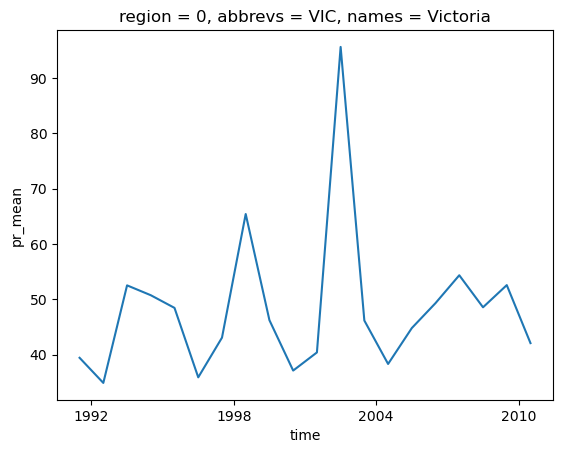

In [25]:
da_mean.squeeze().plot()

In [26]:
%%time
# regional mean
da_mean = acs_regional_stats(ds=ds, var=var, mask = "fractional", start=start, end=end, dims = ("time", "lat", "lon"), how = "mean")
da_mean.to_dataframe()

!warning very slow! Calculating fractional mask every time is very slow.         
Please calculate ```mask = regions.mask_3D_frac_approx(ds)``` before this function.
CPU times: user 18.4 s, sys: 1.99 s, total: 20.4 s
Wall time: 20.3 s


,abbrevs,names,pr_mean
region,,,
0,VIC,Victoria,48.296070
1,NT,Northern Territory,85.385599
2,TAS,Tasmania,56.840691
3,SA,South Australia,41.989914
4,NSW,New South Wales & ACT,57.876824
5,WAN,Western Australia North,78.228344
6,WAS,Western Australia South,48.422522
7,SQ,Queensland South,64.710860
8,NQ,Queensland North,90.654526


In [27]:
%%time
# regional mean
da_mean = acs_regional_stats(ds=ds, var=var, mask = "centred", start=start, end=end, dims = ("time", "lat", "lon"), how = "mean")
da_mean.to_dataframe()

!warning slow! Calculating mask every time is slow.         
Please calculate ```mask = regions.mask_3D(ds)``` before this function.


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/regionmask/core/mask.py:444: UserWarning: Detected overlapping regions. As of v0.11.0 these are correctly taken into account. Note, however, that a different mask is returned than with older versions of regionmask. To suppress this warning, set `overlap=True` (to restore the old, incorrect, behaviour, set `overlap=False`).
  warnings.warn(


CPU times: user 4.3 s, sys: 337 ms, total: 4.64 s
Wall time: 4.65 s


,abbrevs,names,pr_mean
region,,,
0,VIC,Victoria,48.312006
1,NT,Northern Territory,85.496228
2,TAS,Tasmania,56.857886
3,SA,South Australia,41.988238
4,NSW,New South Wales & ACT,57.879046
5,WAN,Western Australia North,78.242107
6,WAS,Western Australia South,48.445728
7,SQ,Queensland South,64.723588
8,NQ,Queensland North,90.683973


In [28]:
%%time
# regional mean
da_mean = acs_regional_stats(ds=ds, var=var, mask = "min_overlap", start=start, end=end, dims = ("time", "lat", "lon"), how = "mean", overlap_threshold=0.3)
da_mean.to_dataframe()


!warning very slow! Calculating fractional mask with minimum overlap every time is very slow.         
Please calculate ```mask = regions.mask_3D_frac_approx(ds) >= overlap_threshold``` before this function.
CPU times: user 18.5 s, sys: 1.99 s, total: 20.5 s
Wall time: 20.4 s


,abbrevs,names,pr_mean
region,,,
0,VIC,Victoria,48.335263
1,NT,Northern Territory,85.455397
2,TAS,Tasmania,56.707086
3,SA,South Australia,42.016959
4,NSW,New South Wales & ACT,57.954367
5,WAN,Western Australia North,78.409615
6,WAS,Western Australia South,48.447449
7,SQ,Queensland South,64.721742
8,NQ,Queensland North,91.023027


In [29]:
%%time
# regional mean
da_mean = acs_regional_stats(ds=ds, var=var, mask =mask_frac, start=start, end=end, dims = ("lat", "lon"), how = "mean")
da_mean.to_dataframe(dim_order=["region", "time"])

CPU times: user 478 ms, sys: 325 ms, total: 803 ms
Wall time: 801 ms


abbrevs      names    pr_mean
region time                                             
0      1991-07-02 12:00:00     VIC   Victoria  39.423784
       1992-07-02 00:00:00     VIC   Victoria  34.878489
       1993-07-02 12:00:00     VIC   Victoria  52.523181
       1994-07-02 12:00:00     VIC   Victoria  50.739155
       1995-07-02 12:00:00     VIC   Victoria  48.449180
...                            ...        ...        ...
9      2006-07-02 12:00:00     AUS  Australia  55.683325
       2007-07-02 12:00:00     AUS  Australia  80.293999
       2008-07-02 00:00:00     AUS  Australia  67.592369
       2009-07-02 12:00:00     AUS  Australia  51.341375
       2010-07-02 12:00:00     AUS  Australia  76.354985

[200 rows x 3 columns]

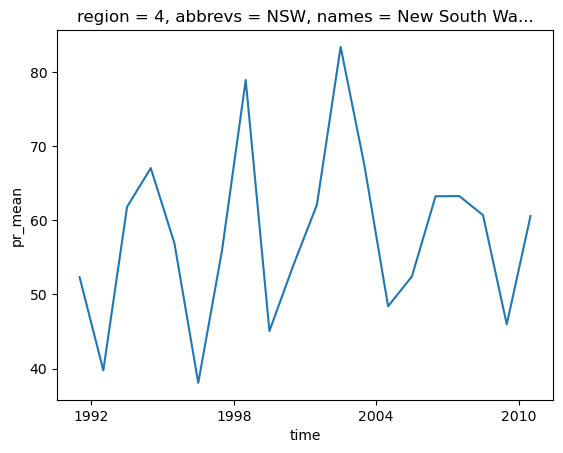

In [30]:
da_mean.sel(region=(regions.abbrevs.index("NSW"))).plot()

In [31]:
%%time
# regional mean
da_mean = acs_regional_stats(ds=ds, var=var, mask =mask_frac, start=start, end=end, dims = ("lat", "lon"), how = "mean")
da_mean.to_dataframe(dim_order=["region", "time"])


CPU times: user 242 ms, sys: 210 ms, total: 452 ms
Wall time: 452 ms


abbrevs      names    pr_mean
region time                                             
0      1991-07-02 12:00:00     VIC   Victoria  39.423784
       1992-07-02 00:00:00     VIC   Victoria  34.878489
       1993-07-02 12:00:00     VIC   Victoria  52.523181
       1994-07-02 12:00:00     VIC   Victoria  50.739155
       1995-07-02 12:00:00     VIC   Victoria  48.449180
...                            ...        ...        ...
9      2006-07-02 12:00:00     AUS  Australia  55.683325
       2007-07-02 12:00:00     AUS  Australia  80.293999
       2008-07-02 00:00:00     AUS  Australia  67.592369
       2009-07-02 12:00:00     AUS  Australia  51.341375
       2010-07-02 12:00:00     AUS  Australia  76.354985

[200 rows x 3 columns]

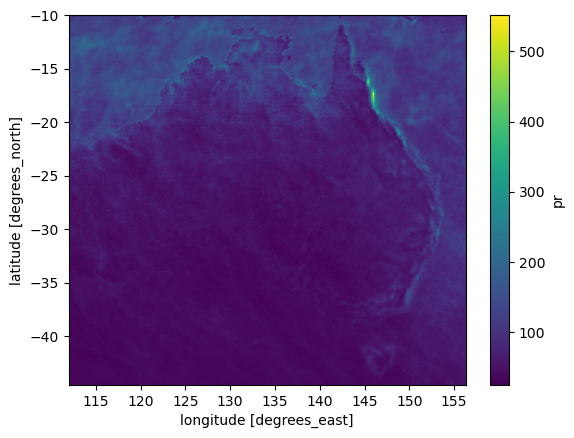

In [32]:
# calculate the mean rx1day value from the 20 years for the global warming level (GWL)
ds = ds.sel(time = slice(start, end))
da_mean = ds["pr"].mean(dim="time")
da_mean.plot()

In [33]:
# import needed packages
from acs_area_statistics import acs_regional_stats, regions
import xarray as xr

In [34]:
# calculate the stats using the acs_region_fractional_stats function
# Find the mean value for each region
filename = "/g/data/ia39/ncra/extratropical_storms/5km/lows_AGCD-05i_ACCESS-CM2_historical_r4i1p1f1_BOM_BARPA-R_v1-r1_annual.nc"
ds = xr.open_dataset(filename, use_cftime = True,)
var = "low_freq"
mask_frac = regions.mask_3D_frac_approx(ds)
start, end = ("1991", "2010")
dims = ("time", "lat", "lon",)

da_mean = acs_regional_stats(ds=ds,var=var, mask=mask_frac, start=start, end=end, dims = dims, how = "mean")
da_mean

<xarray.DataArray 'low_freq_mean' (region: 10)> Size: 80B
array([0.01735532, 0.01274277, 0.02277151, 0.00724128, 0.0119268 ,
       0.0165029 , 0.01099352, 0.00436072, 0.01006063, 0.01105501])
Coordinates:
  * region   (region) int64 80B 0 1 2 3 4 5 6 7 8 9
    abbrevs  (region) <U3 120B 'VIC' 'NT' 'TAS' 'SA' ... 'WAS' 'SQ' 'NQ' 'AUS'
    names    (region) <U23 920B 'Victoria' 'Northern Territory' ... 'Australia'